In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
train_data = pd.read_csv('./data/train.csv')
train_y = train_data.target
train_x = pd.DataFrame(train_data.drop(["target", "ID_code"], axis=1)).reset_index(drop=True)

In [3]:
test_data = pd.read_csv('./data/test.csv')

In [5]:
sub = pd.read_csv('./data/sample_submission.csv')

In [4]:
summary = train_data.describe()

Text(0.5, 1.0, 'Histogram of all predictors')

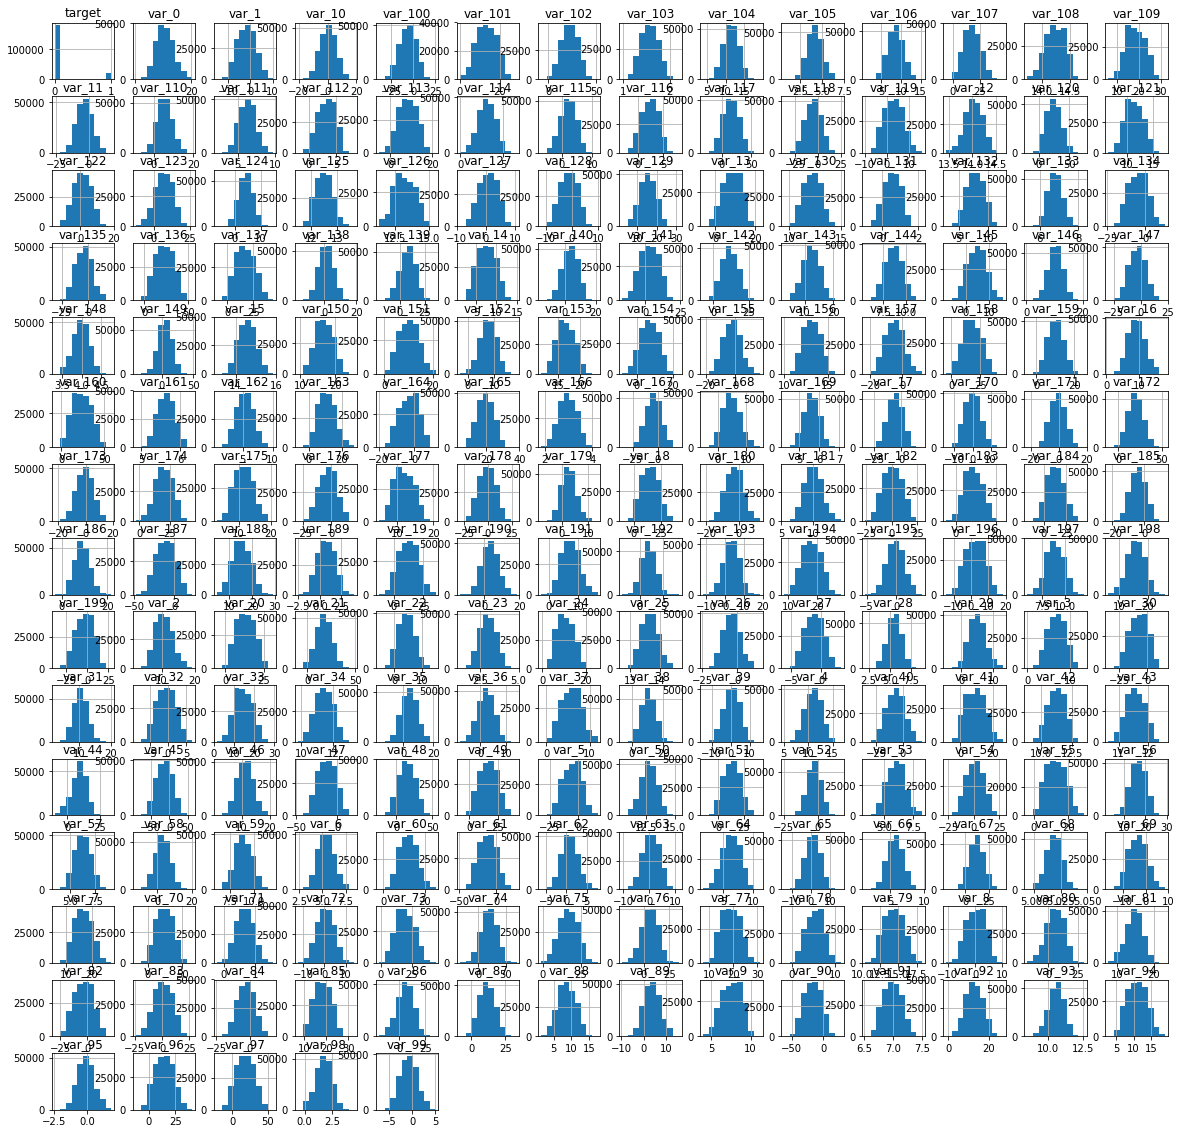

In [6]:
train_data.hist(figsize = (20,20))

plt.tight_layout
plt.title("Histogram of all predictors")

In [7]:
train_data.isnull().sum().sum()

0

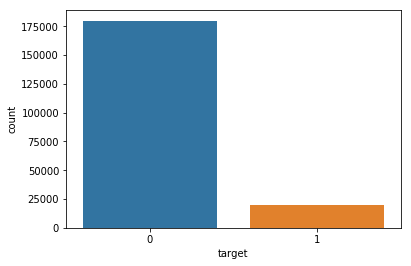

In [8]:
fig = sns.countplot("target", data=train_data)

fig.get_figure().savefig("classImbalance.png")

In [9]:
summary.columns

Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [10]:
summary.var_0

count    200000.000000
mean         10.679914
std           3.040051
min           0.408400
25%           8.453850
50%          10.524750
75%          12.758200
max          20.315000
Name: var_0, dtype: float64

#### Model Building

I don't think there is any more exploratory needed to be built as the data is normalized to an extent and we can go into the assumption that they are all related.

#### Logistic Regression

In [11]:
logRModel = LogisticRegression(random_state=0).fit(train_x, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
logRModel.score(train_x, train_y)

0.91446

In [16]:
ID_Code = test_data["ID_code"]
test_x = pd.DataFrame(test_data.drop(["ID_code"], axis=1)).reset_index(drop=True)

In [17]:
predictions = logRModel.predict(test_x)

In [15]:
sub["target"] = predictions
sub.to_csv("logistic_model_predictions.csv", index=False)

#### Result - 0.630 ROC

### Upsampling data

In [18]:
#Install imblearn: conda install -c conda-forge imbalanced-learn 
from imblearn.over_sampling import SMOTE

In [19]:
print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(train_x, train_y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 20098
Before OverSampling, counts of label '0': 179902 

After OverSampling, the shape of train_X: (359804, 200)
After OverSampling, the shape of train_y: (359804,) 

After OverSampling, counts of label '1': 179902
After OverSampling, counts of label '0': 179902


### LDA Implementation - with upsampled data - lesser score

In [27]:
X_train_datadf=pd.DataFrame(X_train_res)

In [21]:
lda = LinearDiscriminantAnalysis().fit(X_train_datadf, y_train_res)
lda_score1=lda.score(X_train_datadf, y_train_res)
sub["target"] = lda.predict(test_x)
sub.to_csv("lda.csv", index=False)
lda_score1

0.798915520672366

### LDA Implementation -without upsampling - 0.635 ROC

In [73]:
lda = LinearDiscriminantAnalysis().fit(train_x, train_y)
lda_score2=lda.score(train_x, train_y)
sub["target"] = lda.predict(test_x)
sub.to_csv("lda.csv", index=False)
lda_score2

0.914545

###  Exploration of Correlation - Features are not correlated

corrs = train_x.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(20)

### QDA Implementation -without upsampling - 0.635 ROC

In [77]:
qda = QuadraticDiscriminantAnalysis().fit(train_x, train_y)
qda_score1=qda.score(train_x, train_y)
sub["target"] = qda.predict(test_x)
sub.to_csv("qda.csv", index=False)
qda_score1

0.93277

#### Naive Bayes Implementation - Since the features are less correlated , naive bayes might work well.

In [23]:
gaussianNB = GaussianNB()

#### First we'll try without handling class imbalance and using the SMOTE sampled data.

In [28]:
gaussianNB.fit(train_x, train_y)
gaussianNB.score(train_x, train_y)

0.9217

In [29]:
y_train_pred = gaussianNB.predict_proba(train_x)

In [32]:
print('auc on train', roc_auc_score(train_y, y_train_pred[:,1]))  

auc on train 0.8899667114457852


In [35]:
sub["target"] = gaussianNB.predict(test_x)
sub.to_csv("naive_bayes.csv", index=False)

In [ ]:
gaussianNB_smote = GaussianNB()

#### Class Imbalance handled.

In [33]:
gaussianNB_smote = GaussianNB()
gaussianNB_smote.fit(X_train_datadf, y_train_res)
gaussianNB_smote.score(X_train_datadf, y_train_res)

0.8654044980044691

In [36]:
sub["target"] = gaussianNB.predict(test_x)
sub.to_csv("naive_bayes_smote.csv", index=False)

#### Neural network with three hidden layers and 13 neurons each - imbalanced data

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)

In [21]:
mlp.fit(train_x,train_y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [22]:
mlp.score(train_x, train_y)

0.915825

###### on training set accuracy is pretty high

In [23]:
predictions = mlp.predict(test_x)

In [24]:
sub["target"] = predictions
sub.to_csv("NN3.csv", index=False)

#### but on test it comes down to 62.6

#### Neural network with three hidden layers and 13 neurons each - balanced data

In [25]:
mlp_balanced=MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=1000)

In [28]:
mlp_balanced.fit(X_train_datadf, y_train_res)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [30]:
mlp_balanced.score(train_x, train_y)

0.829315

In [29]:
sub["target"] = mlp_balanced.predict(test_x)
sub.to_csv("NN3_balanced.csv", index=False)

#### on upsampling the score on training goes down from 91.5 to 83 but increases on test from 62.6 to 72.5 on same number of neurons and hidden layers

In [33]:
print(y_train_res)

[0 0 0 ... 1 1 1]
